In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Apply PCA

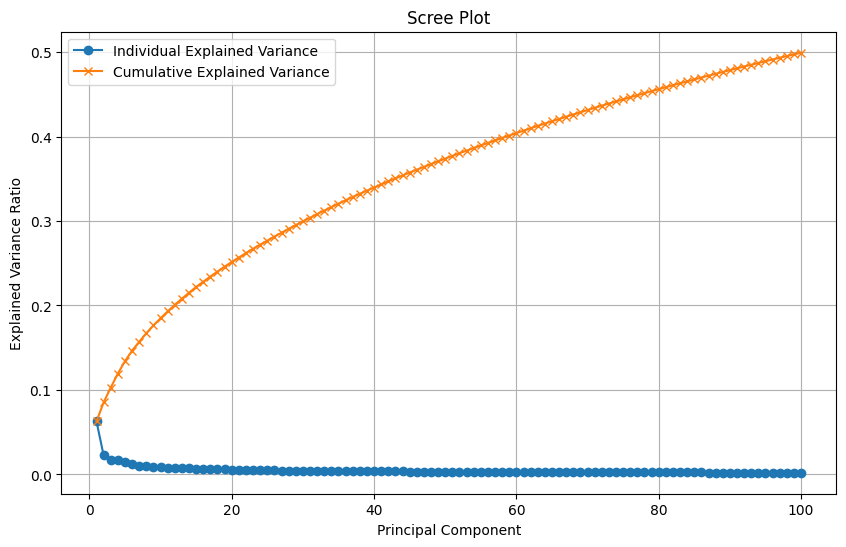

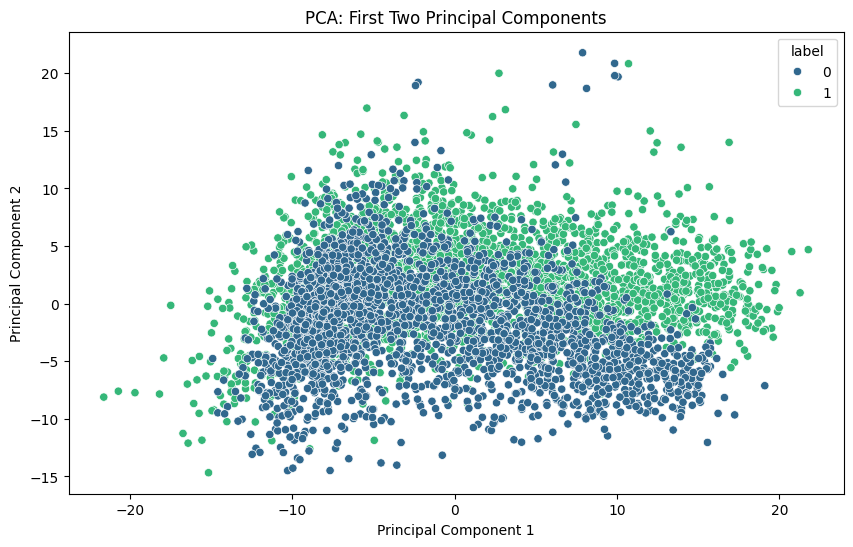

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load balanced dataset
df = pd.read_excel("/content/drive/MyDrive/ML_End_Sem/English/ML_Models_LASER/english_laser_balanced.xlsx")

# Features and labels
X = df[[f'emb_{i}' for i in range(1023)]]
y = df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

# Explained Variance Ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), explained_variance, marker='o', label='Individual Explained Variance')
plt.plot(range(1, 101), cumulative_variance, marker='x', label='Cumulative Explained Variance')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.grid(True)
plt.savefig("scree_plot.png")
plt.show()

# 2D Scatter Plot of First Two Components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
plt.title("PCA: First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.savefig("pca_scatter_plot.png")
plt.show()

# Save PCA-transformed data
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(100)])
pca_df['label'] = y.values
pca_df.to_excel("/content/drive/MyDrive/ML_End_Sem/English/ML_Models_LASER/english_LASAR_pca.xlsx", index=False)

# Save explained variance
pd.DataFrame({
    'Component': range(1, 101),
    'Explained Variance Ratio': explained_variance,
    'Cumulative Variance Ratio': cumulative_variance
}).to_csv("pca_variance.csv", index=False)

ML_Models_SetUp

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Features and labels
X = pca_df[[f'PC{i}' for i in range(1,100)]]
y = pca_df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize results storage
results = {'Model': [], 'Train Accuracy': [], 'Test Accuracy': []}


K-Nearest Neighbors (KNN)


=== KNN ===
Train Accuracy: 0.92725
Test Accuracy: 0.885
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       500
           1       0.88      0.89      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.88      1000
weighted avg       0.89      0.89      0.88      1000

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2000
           1       0.92      0.94      0.93      2000

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



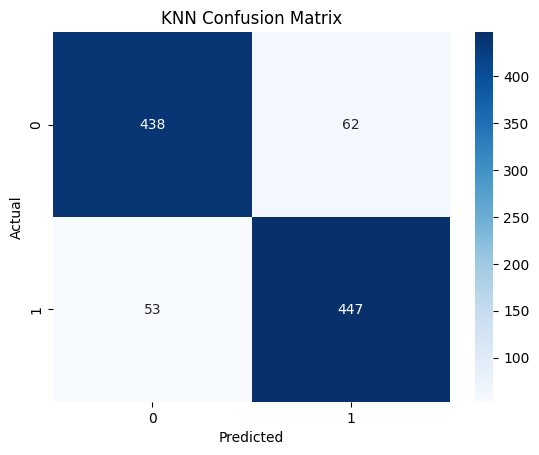

In [5]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('KNN')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

print("\n=== KNN ===")
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print(classification_report(y_test, y_test_pred))
print(classification_report(y_train, y_train_pred))

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


XGBoost

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:36:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost (Tuned) ===
Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Train Accuracy: 0.97
Test Accuracy: 0.902

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       500
           1       0.90      0.90      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000


Classification Report (Train):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2000
           1       0.96      0.98      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



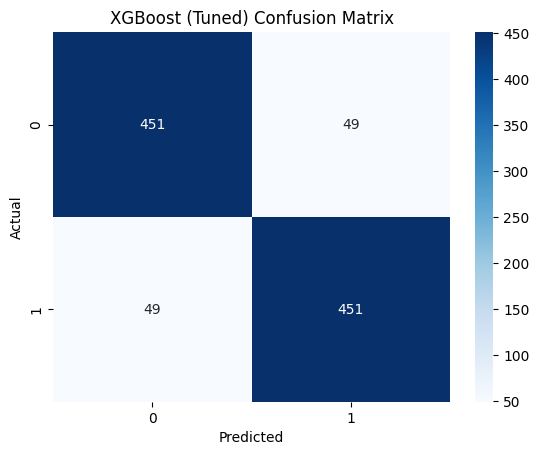

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define a small search space for speed
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=15,  # reduce or increase based on time
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Predict
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('XGBoost (Tuned)')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

# Output
print("\n=== XGBoost (Tuned) ===")
print("Best Parameters:", random_search.best_params_)
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost (Tuned) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Random Forest



=== Random Forest ===
Train Accuracy: 1.0
Test Accuracy: 0.868
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       500
           1       0.87      0.87      0.87       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



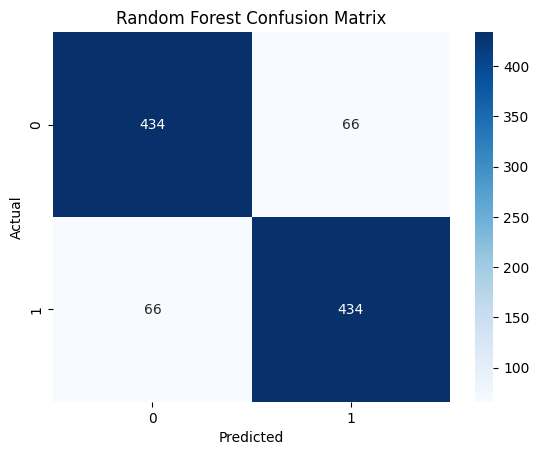

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('Random Forest')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

print("\n=== Random Forest ===")
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print(classification_report(y_test, y_test_pred))
print(classification_report(y_train, y_train_pred))

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Random_Forest_Hyperparameter_tuning

Fitting 3 folds for each of 15 candidates, totalling 45 fits

=== Random Forest (Tuned) ===
Best Parameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Train Accuracy: 1.0
Test Accuracy: 0.887

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       500
           1       0.89      0.89      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000


Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



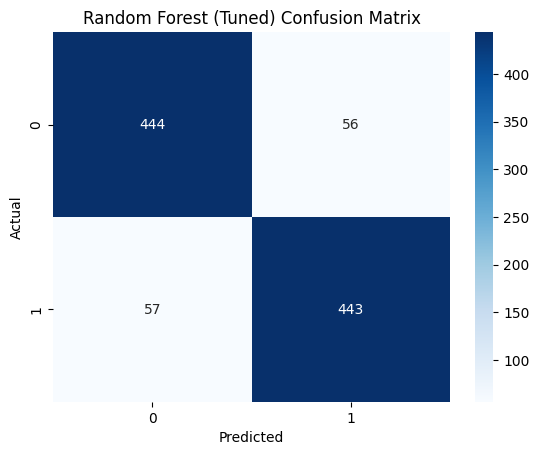

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define a small hyperparameter space for speed
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Base model
rf = RandomForestClassifier(random_state=42)

# Fast randomized search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,         # Tune this for speed vs performance
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Predict
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('Random Forest (Tuned)')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

# Output
print("\n=== Random Forest (Tuned) ===")
print("Best Parameters:", random_search.best_params_)
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest (Tuned) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Decision Tree


=== Decision Tree ===
Train Accuracy: 1.0
Test Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       500
           1       0.79      0.76      0.78       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



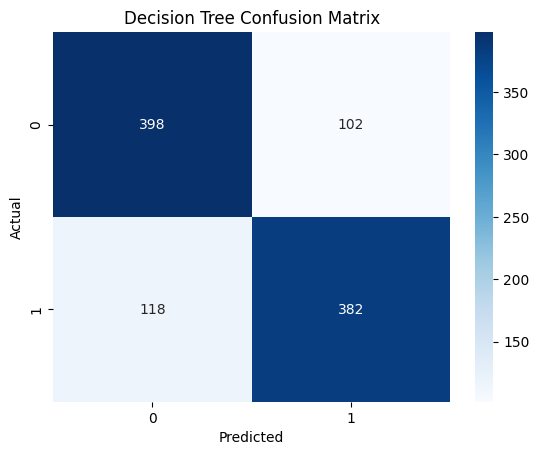

In [10]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('Decision Tree')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

print("\n=== Decision Tree ===")
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print(classification_report(y_test, y_test_pred))
print(classification_report(y_train, y_train_pred))

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Decesion_tree_hyperparameter_tunning

Fitting 3 folds for each of 15 candidates, totalling 45 fits

=== Decision Tree (Tuned) ===
Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5, 'criterion': 'gini'}
Train Accuracy: 0.819
Test Accuracy: 0.79

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       500
           1       0.76      0.84      0.80       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000


Classification Report (Train):
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      2000
           1       0.79      0.87      0.83      2000

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



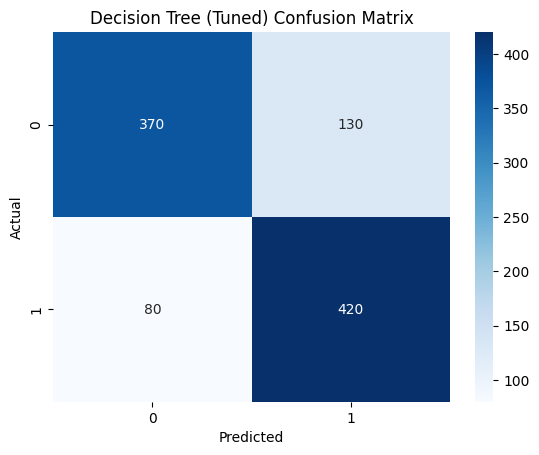

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fast hyperparameter grid
param_dist = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

# Base model
dt = DecisionTreeClassifier(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=15,     # Reduce to 10 or 5 for faster search
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Predict
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('Decision Tree (Tuned)')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

# Output
print("\n=== Decision Tree (Tuned) ===")
print("Best Parameters:", random_search.best_params_)
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree (Tuned) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


MLP (Neural Network)


=== MLP ===
Train Accuracy: 1.0
Test Accuracy: 0.921
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       500
           1       0.94      0.90      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



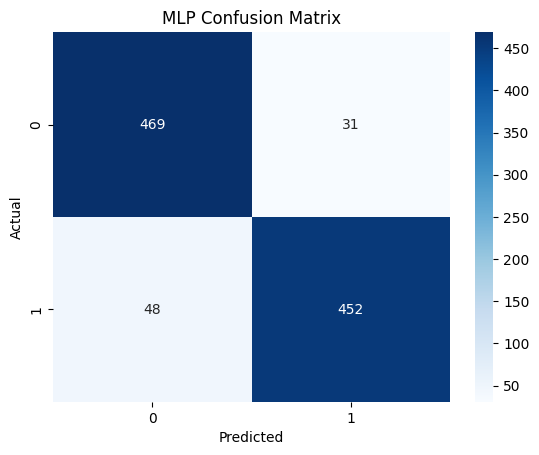

In [12]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('MLP')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

print("\n=== MLP ===")
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print(classification_report(y_test, y_test_pred))

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


MLP_HP

Fitting 3 folds for each of 10 candidates, totalling 30 fits

=== MLP (Tuned) ===
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'activation': 'relu'}
Train Accuracy: 1.0
Test Accuracy: 0.922

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       500
           1       0.94      0.90      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



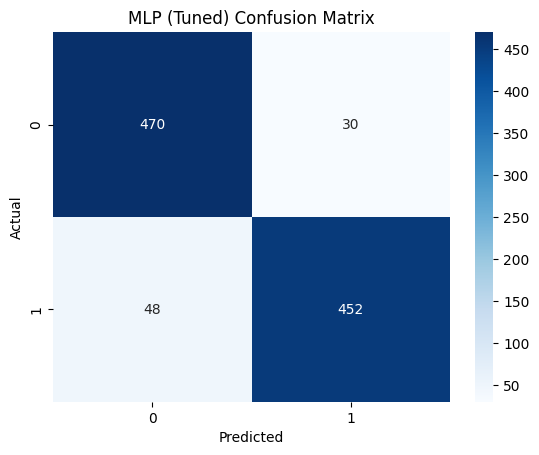

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fast hyperparameter space
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Base model
mlp = MLPClassifier(max_iter=500, random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=10,    # Tune this for speed vs accuracy
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit model
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('MLP (Tuned)')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

# Output
print("\n=== MLP (Tuned) ===")
print("Best Parameters:", random_search.best_params_)
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("MLP (Tuned) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Support Vector Machine (SVM)


=== SVM ===
Train Accuracy: 0.978
Test Accuracy: 0.931
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       500
           1       0.93      0.93      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2000
           1       0.97      0.99      0.98      2000

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



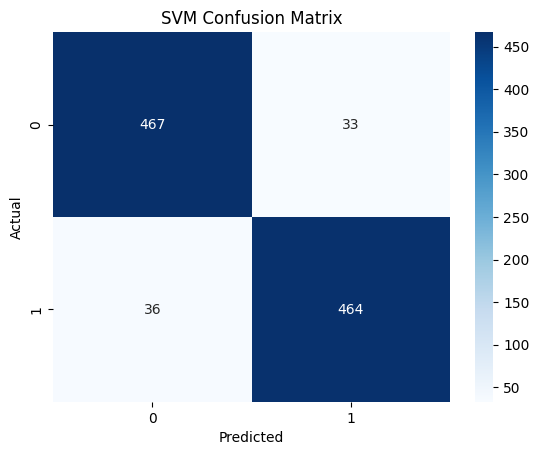

In [14]:
from sklearn.svm import SVC

model = SVC(probability=True, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('SVM')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

print("\n=== SVM ===")
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print(classification_report(y_test, y_test_pred))
print(classification_report(y_train, y_train_pred))

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Naive Bayes


=== Naive Bayes ===
Train Accuracy: 0.86275
Test Accuracy: 0.852
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       500
           1       0.86      0.84      0.85       500

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2000
           1       0.86      0.87      0.86      2000

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000



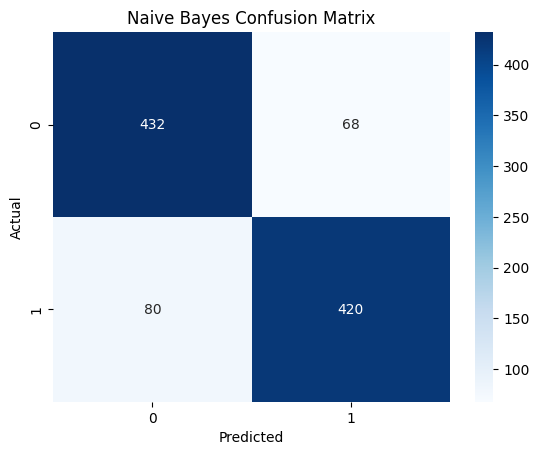

In [15]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('Naive Bayes')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

print("\n=== Naive Bayes ===")
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print(classification_report(y_test, y_test_pred))
print(classification_report(y_train, y_train_pred))

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Stacking Classifier


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:47:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:47:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


=== Stacking Classifier ===
Train Accuracy: 0.99275
Test Accuracy: 0.926
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       500
           1       0.94      0.91      0.92       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



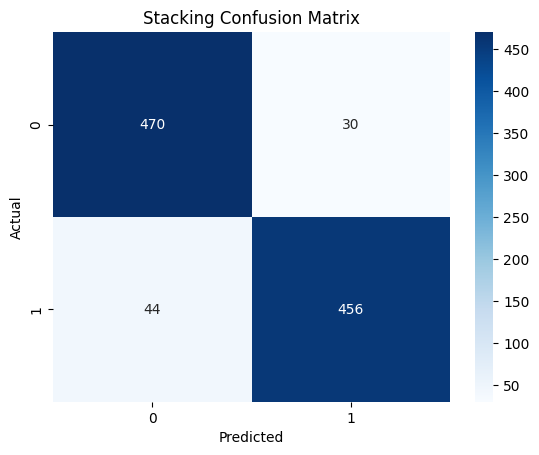

In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base models again
base_models = [
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('DT', DecisionTreeClassifier(random_state=42)),
    ('MLP', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)),
    ('SVM', SVC(probability=True, random_state=42)),
    ('NB', GaussianNB())
]

model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
results['Model'].append('Stacking')
results['Train Accuracy'].append(train_acc)
results['Test Accuracy'].append(test_acc)

print("\n=== Stacking Classifier ===")
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print(classification_report(y_test, y_test_pred))

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Stacking Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Final Accuracy Comparison Plot

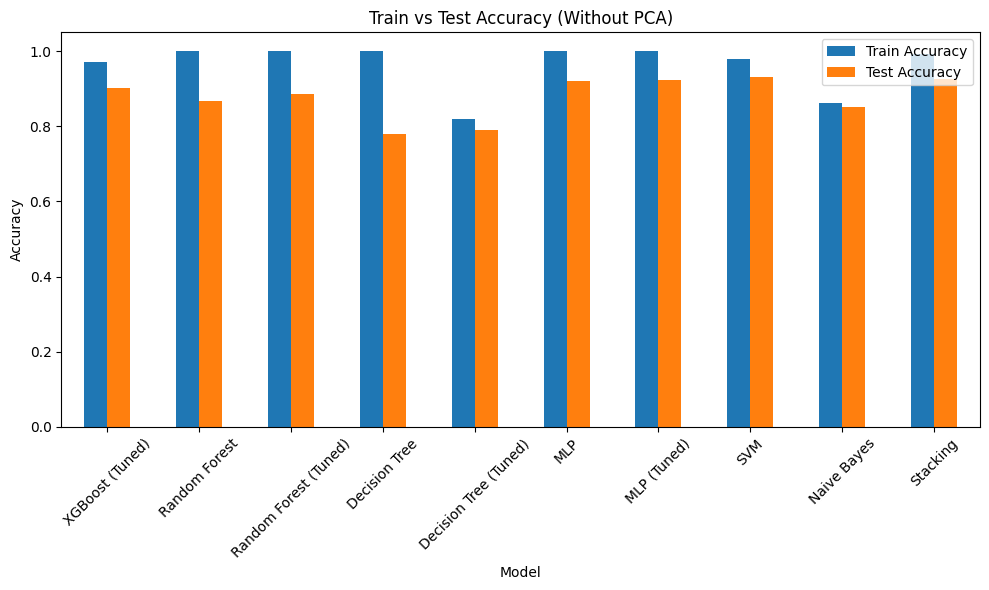

In [17]:
results_df = pd.DataFrame(results)
results_df = results_df.drop_duplicates(subset='Model')  # Drop duplicate models

results_df.set_index('Model')[['Train Accuracy', 'Test Accuracy']].plot(kind='bar', figsize=(10, 6))
plt.title("Train vs Test Accuracy (Without PCA)")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("accuracy_comparison_without_pca.png")
plt.show()

# Save results
results_df.to_csv("model_results_without_pca.csv", index=False)
